In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [11]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                            | 5041/11261 [01:30<01:43, 60.37it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8777/11261 [02:48<01:04, 38.74it/s]

index 0 is out of bounds for axis 0 with size 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [03:41<00:00, 50.80it/s]


In [12]:
model_end = 2021
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [13]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=["sma_corr","sma","ema","ema_corr"]
                                                            ,num_of_groups=[5,10]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[3,5,10]
                                                            ,min_prices=[1,3,5]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and portfolio.selection_type.label == "top_blacklist" \
            and portfolio.position_type.label == "long" and portfolio.allocation_type.label == "equal" and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

336

In [14]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [58:50<00:00, 10.51s/it]


In [15]:
a = pd.DataFrame(analysises)

In [16]:
metric = "raw_pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,max_price,min_price,rolling_window,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
193,ema,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,5,1,10,2.065074e+07,2.669364e+09,0.950000,6.225384,3.317183e+06,1.065031,0.966013,0.488889,1.014422,6.225384,<financial_common.portfolio_management.portfol...
24,sma_corr,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,3,1,10,3.080649e+06,8.083225e+08,0.951190,5.961026,5.167984e+05,1.057613,0.966543,0.507543,1.012765,5.961021,<financial_common.portfolio_management.portfol...
108,sma,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,3,1,10,2.423832e+06,5.866677e+08,0.951190,6.115817,3.963219e+05,1.058077,0.966512,0.503001,1.012570,6.115809,<financial_common.portfolio_management.portfol...
25,sma_corr,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,5,1,10,5.546880e+06,5.266672e+08,0.950000,5.838861,9.499935e+05,1.061563,0.966257,0.493106,1.013253,5.838858,<financial_common.portfolio_management.portfol...
199,ema,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,10,5,1,10,6.632280e+05,3.905007e+08,0.952499,5.123391,1.294510e+05,1.057155,0.966861,0.491890,1.011276,5.123369,<financial_common.portfolio_management.portfol...
204,ema,long,SIMPLE_MOVING_AVERAGE,top_blacklist,0.05,5,3,1,10,1.067610e+06,3.431490e+08,0.950000,5.004940,2.133112e+05,1.057821,0.965833,0.501217,1.011939,5.004927,<financial_common.portfolio_management.portfol...
109,sma,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,5,1,10,3.433406e+06,3.284674e+08,0.950000,5.959958,5.760789e+05,1.061409,0.966172,0.490187,1.012856,5.959953,<financial_common.portfolio_management.portfol...
121,sma,long,SIMPLE_MOVING_AVERAGE,top_blacklist,0.05,5,5,1,10,5.887002e+05,2.950280e+08,0.950000,5.930556,9.926559e+04,1.060005,0.965907,0.483861,1.011437,5.930527,<financial_common.portfolio_management.portfol...
192,ema,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,5,3,1,10,1.352901e+06,2.868830e+08,0.950541,6.543998,2.067393e+05,1.058928,0.966260,0.494728,1.012106,6.543984,<financial_common.portfolio_management.portfol...
205,ema,long,SIMPLE_MOVING_AVERAGE,top_blacklist,0.05,5,5,1,10,2.903269e+05,2.800741e+08,0.950000,5.225835,5.555609e+04,1.058535,0.965645,0.486456,1.010832,5.225783,<financial_common.portfolio_management.portfol...


In [36]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [27]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

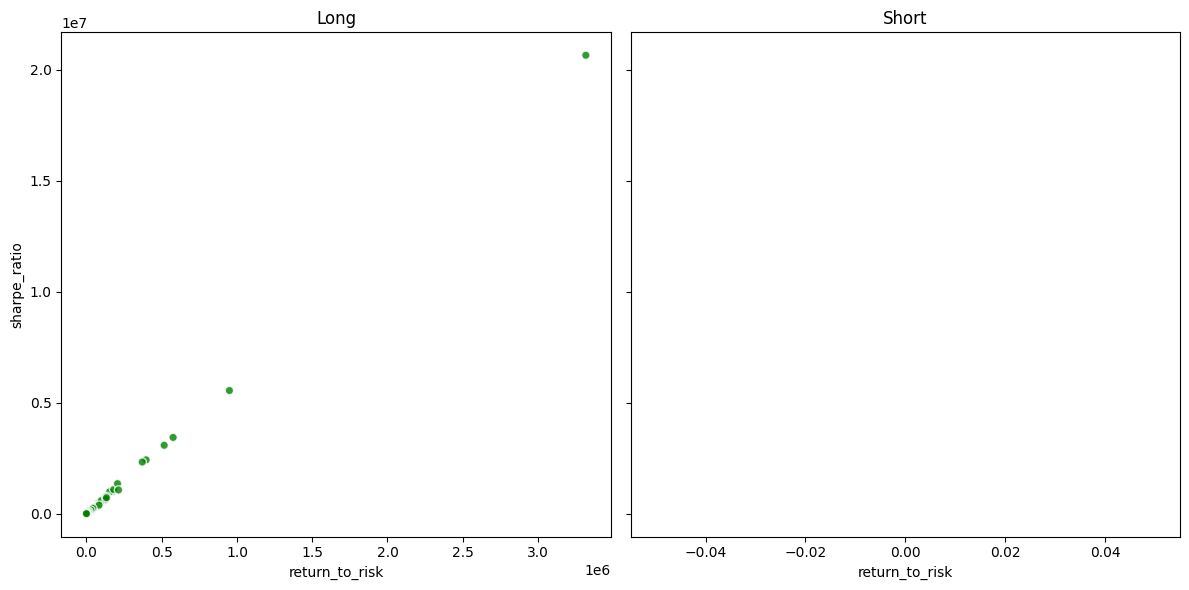

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [29]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

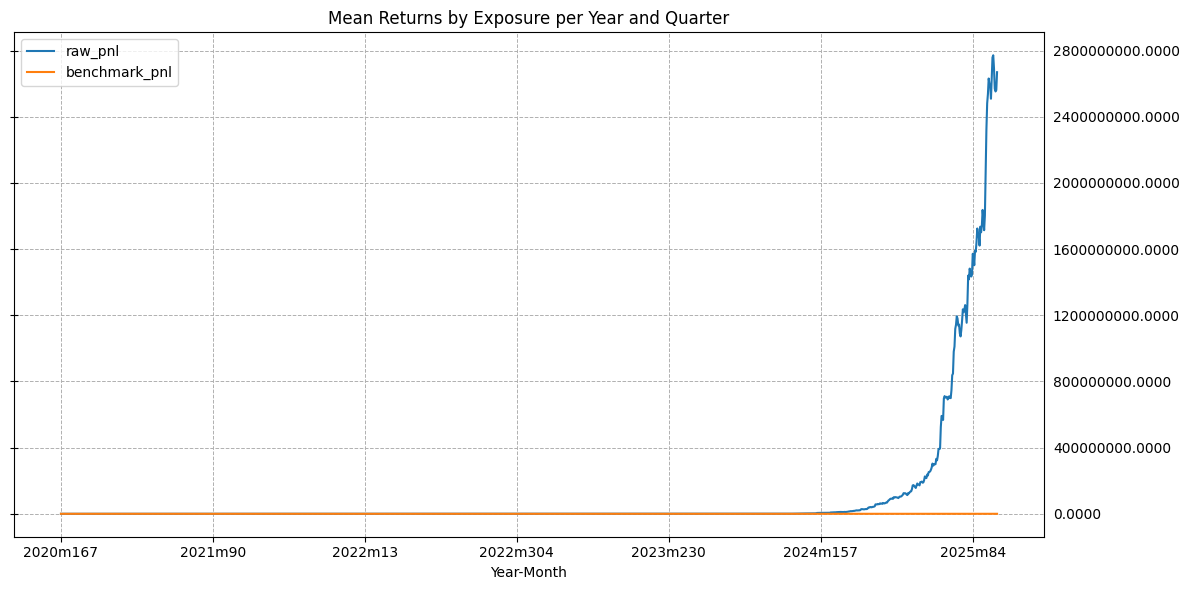

In [30]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [37]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
GOVX,1.438944
PSQH,1.285714
SRFM,1.282118
RLMD,1.264925
FOXX,1.260002
...,...
CNTY,0.950000
DVLT,0.950000
ACRV,0.950000


In [32]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,167,2020-06-15 00:00:00+00:00,1.005452,1.005452,1.005452e+00,1.005452e+00,88.07,1.000000,6,2,25,2020m167
1,1,2020,168,2020-06-16 00:00:00+00:00,0.979070,0.979070,9.844072e-01,9.844072e-01,88.78,1.008062,6,2,25,2020m168
2,2,2020,169,2020-06-17 00:00:00+00:00,0.996307,0.996307,9.807721e-01,9.807721e-01,86.53,0.982514,6,2,25,2020m169
3,3,2020,170,2020-06-18 00:00:00+00:00,0.984942,0.984942,9.660039e-01,9.660039e-01,86.06,0.977177,6,2,25,2020m170
4,4,2020,171,2020-06-19 00:00:00+00:00,0.983906,0.983906,9.504568e-01,9.504568e-01,85.08,0.966050,6,2,25,2020m171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1228,2025,125,2025-05-05 00:00:00+00:00,0.970971,0.970971,2.082062e+07,2.691323e+09,252.56,2.867719,5,2,19,2025m125
1229,1229,2025,126,2025-05-06 00:00:00+00:00,0.954737,0.954737,1.987821e+07,2.569505e+09,249.25,2.830135,5,2,19,2025m126
1230,1230,2025,127,2025-05-07 00:00:00+00:00,0.993553,0.993553,1.975006e+07,2.552940e+09,249.39,2.831725,5,2,19,2025m127
1231,1231,2025,128,2025-05-08 00:00:00+00:00,1.003209,1.003209,1.981343e+07,2.561131e+09,253.47,2.878052,5,2,19,2025m128


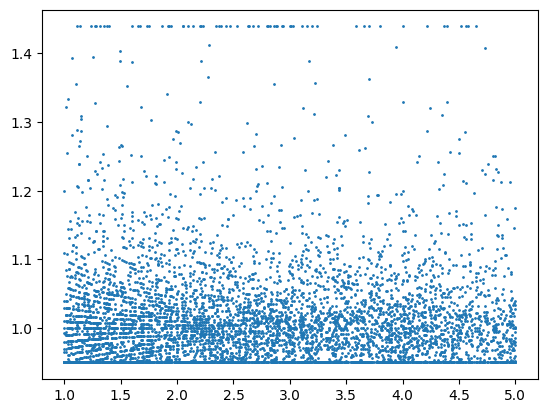

In [33]:
plt.scatter(trades["adjclose"],trades["return"],s=1)
plt.show()

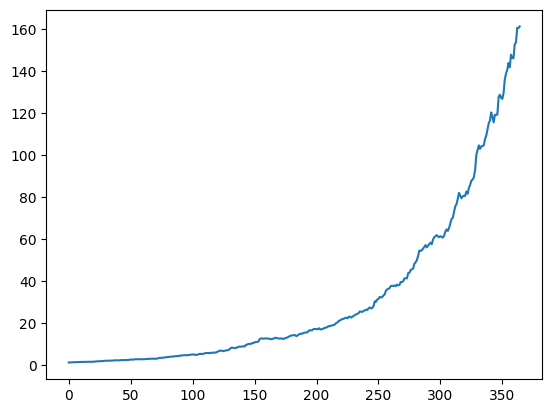

In [34]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [35]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,rolling_dollar_volume,ema,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
6145,2025,94,ALDX,2025-04-04 00:00:00+00:00,1.8900,1.950,1.077223e+07,3.674839,0.259033,1,...,1.0,1,1.031746,1.031746,1.031746,1.031746,1.031746,4,2,14
6146,2025,94,ACRV,2025-04-04 00:00:00+00:00,1.5100,1.390,1.032363e+06,1.695896,0.427269,2,...,1.0,1,0.920530,0.950000,0.950000,0.950000,0.950000,4,2,14
6147,2025,94,INV,2025-04-04 00:00:00+00:00,4.8200,4.370,3.920458e+05,1.686198,0.161324,3,...,1.0,1,0.906639,0.950000,0.950000,0.950000,0.950000,4,2,14
6148,2025,94,SHFS,2025-04-04 00:00:00+00:00,2.2300,2.220,9.039883e+04,1.683731,0.235877,4,...,1.0,1,0.995516,0.995516,0.995516,0.995516,0.995516,4,2,14
6149,2025,94,ADN,2025-04-04 00:00:00+00:00,2.9800,3.065,4.486553e+04,1.333631,0.171439,5,...,1.0,1,1.028523,1.028523,1.028523,1.028523,1.028523,4,2,14
6150,2025,97,ALDX,2025-04-07 00:00:00+00:00,1.9500,1.920,1.279722e+07,2.440810,0.310032,1,...,1.0,1,0.984615,0.984615,0.984615,0.984615,0.984615,4,2,15
6151,2025,97,GRI,2025-04-07 00:00:00+00:00,1.4000,1.270,3.245746e+06,2.277263,0.456632,2,...,1.0,1,0.907143,0.950000,0.950000,0.950000,0.950000,4,2,15
6152,2025,97,CNSP,2025-04-07 00:00:00+00:00,1.1200,1.030,7.240152e+05,1.440701,0.463798,3,...,1.0,1,0.919643,0.950000,0.950000,0.950000,0.950000,4,2,15
6153,2025,97,SHFS,2025-04-07 00:00:00+00:00,2.2200,2.220,8.159194e+04,1.701500,0.265312,4,...,1.0,1,1.000000,1.000000,1.000000,1.000000,1.000000,4,2,15
6154,2025,97,MOVE,2025-04-07 00:00:00+00:00,1.2026,1.105,5.033061e+04,1.367571,0.255971,5,...,1.0,1,0.918843,0.950000,0.950000,0.950000,0.950000,4,2,15
